In [1]:
import numpy as np # scientific computing
import pandas as pd # data loading and processing
import os # os operations
import matplotlib.pyplot as plt # for generating figures
import math
import matplotlib.dates as mdates
import seaborn as sns # for generating visualizations, better support with pandas than matplotlib
from sklearn.impute import SimpleImputer

# Colorectal data analysis

In [2]:
def get_gene_names(filename,col=None):
    file = pd.read_csv(filename, index_col=None, header= 0).T
    names = file[col].dropna().tolist()
    return names

def construct_filename(c, db):
    if db =="xena":
        n1 = "./data/" + "TCGA." + c + ".sampleMap_HiSeqV2"
        n2 = "./data/" + "TCGA." + c + ".sampleMap_"+ c +"_clinicalMatrix"
    elif db == "cbio":
        n1 = "./data/" + c+"_data_mrna_seq_v2_rsem.txt"
        n2 = "./data/" + c + "_data_clinical_sample.txt"
    else:
        print("db must be either xena or cbio")
    return n1,n2

def construct_hccdb_filename(n):
    n1 = "./data/HCCDB/HCCDB" + n + "_mRNA_level3.txt"
    n2 = "./data/HCCDB/HCCDB" + n  + ".sample.txt"
    return n1,n2

def process_data(df, targets, x_var_names = None, y_var_names = None, pheno_filtered=None):

    # df is inputted as gene x patient 

    df = df.T # patients x genes

    # subset to get relevant genes
    df_filtered = df[targets]
    # print(df_filtered.isnull().any())

    # # check for nan values
    # na_filter = df_filtered.isnull().any()
    # na_ls = na_filter[na_filter == True].index.to_list()
    # print(na_ls)
    
    # # impute nan values with the mean of the gene
    # if na_ls != []:
    #     mean_ls = df_filtered.mean()
    #     for na_col in na_ls:
    #         df_filtered[na_col] = df_filtered[na_col].fillna(mean_ls[na_col])
    
    # print(df_filtered.isnull().any())

    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    output = imp_mean.fit_transform(df_filtered)
    df_filtered = pd.DataFrame(output, columns = df_filtered.columns, index = df_filtered.index)
    
    df_filtered = df_filtered.astype(np.float64)

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    df_filtered=(df_filtered-df_filtered.median())/(df_filtered.std()+1)

    data = df_filtered  

    if x_var_names != None:
        x_var_gene_set = data[x_var_names]
        x_var_gene_set["x_composite_score"] = x_var_gene_set.mean(axis = 1)
        data = pd.concat([data, x_var_gene_set[["x_composite_score"]]], axis = 1) 
    
    if y_var_names != None:
        # take only nrf2 target genes
        y_var_gene_set = data[y_var_names]
        y_var_gene_set["y_composite_score"]= y_var_gene_set.mean(axis = 1)
        data = pd.concat([data, y_var_gene_set[["y_composite_score"] ]], axis = 1) # patients x genes 
    
    return data

def analyse(data, fig, name, ax, fn, x_label, y_label, x_target = "RRM2B", y_target = "composite_score", ):
    #find line of best fit
    y, x = data[y_target].to_numpy(), data[x_target].to_numpy()
    a, b = np.polyfit(x, y, 1)

    iqr = data[x_target].T.describe()

    # bin the patients into quartiles based on G6PD expression
    data["RRM2B levels"] = pd.cut(data["RRM2B"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]

    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2
    
    if p < 0.0001:
        pval = "<0.0001"
    elif p <0.001:
        pval = "<0.001"
    elif p<0.01:
        pval = "<0.01"
    elif p<0.05:
        pval = "<0.05"
    else:
        pval = "N.S."

    # plot the data
    # scatter plot for RRM2B against NRF2 activity
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x=x_target, y=y_target, ax= ax)
    ax.plot(x, a*x+b, color="black")
    ax.set_ylabel(y_label,fontsize = 28)
    ax.set_xlabel(x_label + " \n (r = " + str(round(r, 4)) + "," + " p = " + pval +")",fontsize = 25)
    ax.set_title(name, fontsize = 30)
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.show()

    # save the figure 
    fig.savefig(fn)
    return r, p

def get_targets_present(data, targets):
    idx = data.index.to_list()
    # print(idx)
    # print(targets)
    targets_present = list(set(idx).intersection(set(targets)))
    # print(targets_present)
    return targets_present

def get_xena_data(n1):
    df = pd.read_csv(n1, index_col = 0, sep = "\t") # gene x patient
    return df

def get_cbio_data(n1):
    df = pd.read_csv(n1, index_col = 0, sep = "\t").drop(["Entrez_Gene_Id"], axis=1) # gene x patient
    return df

def get_hccdb_data(n1):
    df = pd.read_csv(n1, index_col = 1, sep = "\t").drop(["Entrez_ID"], axis=1) # gene x patient
    return df

def get_xena_pheno(n2):
    pheno = pd.read_csv(n2, index_col=0, sep = "\t")
    pheno = pheno[["sample_type"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered

def get_cbio_pheno(n2):
    pheno = pd.read_csv(n2, index_col=1,header = 4, sep = "\t")
    pheno = pheno[["SAMPLE_TYPE"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered

def get_hccdb_pheno(n2):
    pheno = pd.read_csv(n2, index_col=0, sep = "\t").T
    pheno = pheno[["TYPE"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered



In [3]:
# load colorectal data
df = pd.read_csv("./data/TCGA.COADREAD.sampleMap_HiSeqV2", index_col=0, sep = "\t")
df

,TCGA-CA-5256-01,TCGA-AZ-6599-01,TCGA-AA-3655-01,TCGA-A6-6137-01,TCGA-CK-4952-01,TCGA-A6-5657-01,TCGA-AD-6963-01,TCGA-AA-3663-11,TCGA-A6-6138-01,TCGA-A6-A567-01,...,TCGA-CI-6620-01,TCGA-AG-3725-01,TCGA-AH-6643-01,TCGA-DY-A0XA-01,TCGA-AF-3400-11,TCGA-EI-6506-01,TCGA-AF-2692-11,TCGA-AF-A56K-01,TCGA-DC-6154-01,TCGA-AG-3592-01
sample,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,10.1616,11.1212,11.0245,11.0576,10.5660,10.4189,10.8635,11.0543,10.3716,11.5113,...,10.9090,11.2637,10.3559,10.4947,11.4043,11.3188,10.7338,10.7196,11.3442,10.7753
HIF3A,3.7172,2.3437,2.0858,6.0759,1.9506,5.4777,4.4634,8.4492,1.8943,4.7474,...,3.3234,1.4272,2.3162,3.1015,5.7645,3.0008,7.7070,6.7224,6.1021,5.0876
RNF17,0.0000,0.0000,0.5495,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
RNF10,10.4857,11.6878,11.5062,11.7053,11.8684,11.4861,11.4397,11.9238,11.7580,11.4303,...,11.3939,12.0311,11.6253,11.3194,12.1388,11.5119,11.8789,11.1103,11.5538,11.3385
RNF11,10.5157,10.3830,9.9334,10.2443,9.8537,10.1777,9.3104,11.0780,10.4115,10.6953,...,9.6838,10.3410,10.1512,9.8840,10.4810,9.9720,11.2593,9.6058,9.7442,9.2784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PTRF,9.4792,8.9279,10.6716,10.5038,10.4412,12.5156,10.2790,13.3075,11.5264,11.1985,...,12.6033,9.4449,11.3169,10.3013,10.7764,10.7430,13.7595,12.2902,11.3946,10.8611
BCL6B,5.7645,4.8842,7.0262,6.9352,6.7306,7.7286,6.3278,7.0410,7.2633,6.8165,...,8.1765,5.8791,7.5720,6.6007,5.7905,7.3037,8.2791,8.6242,7.8983,7.0589
GSTK1,12.5517,11.6017,12.4103,11.2349,10.5621,11.3806,11.8569,11.8092,12.0823,12.3234,...,11.5012,12.6351,11.5202,11.3869,12.0445,11.0788,11.3977,11.2602,11.8158,12.1677


In [5]:
df.loc["RRM2B"]

TCGA-CA-5256-01    10.0057
TCGA-AZ-6599-01     8.8974
TCGA-AA-3655-01     8.9640
TCGA-A6-6137-01     9.5851
TCGA-CK-4952-01     9.1454
                    ...   
TCGA-EI-6506-01     8.1417
TCGA-AF-2692-11     9.5414
TCGA-AF-A56K-01     9.6599
TCGA-DC-6154-01    10.4017
TCGA-AG-3592-01     8.8145
Name: RRM2B, Length: 434, dtype: float64

In [24]:
targets = ["G6PD", "RRM2B","BAX","AEN","CCNG1", "CDKN1A", "DDB2", "FDXR", "MDM2", "RPS27L", "RRM2B", "SESN1", "TNFRSF10B", "XPC", "ZMAT3"]
d = process_data(df, targets, x_var_names = ["RRM2B"], y_var_names = ["G6PD"], pheno_filtered=None)

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_87552/2473273804.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_var_gene_set["x_composite_score"] = x_var_gene_set.mean(axis = 1)
/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_87552/2473273804.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_var_gene_set["y_composite_score"]= y_var_gene_set.mean(axis = 1)


In [ ]:
d

In [25]:
d

sample,G6PD,RRM2B,BAX,AEN,CCNG1,CDKN1A,DDB2,FDXR,MDM2,RPS27L,RRM2B,SESN1,TNFRSF10B,XPC,ZMAT3,x_composite_score,y_composite_score
TCGA-CA-5256-01,-0.024029,0.026211,0.029951,0.023338,0.035228,0.027555,0.027389,0.040878,-0.000487,0.028492,0.026211,0.065192,0.015788,-0.035914,0.030091,0.026211,-0.024029
TCGA-AZ-6599-01,-0.033398,-0.018821,0.002600,0.027729,-0.012099,0.007008,0.024742,0.000683,0.022480,0.024669,-0.018821,-0.036190,0.009920,0.005196,-0.028427,-0.018821,-0.033398
TCGA-AA-3655-01,0.021224,-0.015976,-0.011915,0.004675,-0.009034,-0.016523,-0.014184,0.015197,0.002369,-0.030481,-0.015976,-0.130415,0.026325,-0.002225,-0.027925,-0.015976,0.021224
TCGA-A6-6137-01,0.006958,0.009679,-0.008789,-0.021357,-0.017951,0.006288,-0.020062,-0.013378,-0.005580,-0.020070,0.009679,0.019924,-0.032886,0.007351,0.026376,0.009679,0.006958
TCGA-CK-4952-01,-0.027458,-0.008321,-0.011744,0.023004,-0.009013,-0.009911,0.041801,-0.006374,0.023666,0.013867,-0.008321,-0.080642,-0.021520,0.004474,-0.060545,-0.008321,-0.027458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EI-6506-01,0.010704,-0.052518,0.014989,0.007712,-0.015473,0.021977,-0.026435,-0.025833,-0.017033,-0.002617,-0.052518,0.010243,0.014339,0.001828,0.024832,-0.052518,0.010704
TCGA-AF-2692-11,-0.021744,0.007924,-0.015704,0.007490,0.000010,0.035340,0.010273,-0.018370,0.000436,0.005733,0.007924,-0.029795,-0.028824,-0.006012,0.030151,0.007924,-0.021744
TCGA-AF-A56K-01,0.002847,0.012666,0.001753,0.005807,-0.056702,-0.010286,-0.028886,0.010078,0.001350,-0.013020,0.012666,0.044487,0.019913,0.012490,-0.005741,0.012666,0.002847
TCGA-DC-6154-01,0.004965,0.041208,-0.022484,-0.027874,-0.021210,-0.025331,-0.013435,0.016266,-0.025353,0.004760,0.041208,-0.001779,-0.006704,0.002907,-0.067686,0.041208,0.004965


In [74]:
# data = df.loc[["G6PD", "RRM2B","BAX","AEN","CCNG1", "CDKN1A", "DDB2", "FDXR", "MDM2", "RPS27L", "RRM2B", "SESN1", "TNFRSF10B", "XPC", "ZMAT3"]]

In [75]:
# get names of nrf2 target genes
# nrf2_names = pd.read_csv("nrf2 target genes.csv", index_col=None, header= None).T
# nrf2_names = nrf2_names.loc[0].to_list()

# get relevant genes (RRM2B and NRF2 target genes)
# data = df.loc[["G6PD", "RRM2B","BAX","AEN","CCNG1", "CDKN1A", "DDB2", "FDXR", "MDM2", "RPS27L",  "SESN1", "TNFRSF10B", "XPC", "ZMAT3"]]

# # get only patients with cancer samples
# nrf2 = nrf2[patients]

# data.head() # genes x patients


In [76]:
df = df.T

# bin the patients into quartiles based on RRM2B expression
iqr = df["RRM2B"].describe()
df["RRM2B_levels"] = pd.cut(df["RRM2B"],
                bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                labels=["Bottom 25%", "-", "Top 25%"])
df.drop(df.loc[df["RRM2B_levels"]=="-"].index, inplace=True)



In [78]:
high = df[df["RRM2B_levels"] == "Top 25%"]
low = df[df["RRM2B_levels"] == "Bottom 25%"]

high.drop("RRM2B_levels", axis = 1, inplace=True)
low.drop("RRM2B_levels", axis = 1, inplace=True)

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_2426/2772145204.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high.drop("RRM2B_levels", axis = 1, inplace=True)
/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_2426/2772145204.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low.drop("RRM2B_levels", axis = 1, inplace=True)


In [80]:
high.loc["mean high"] = high.mean()
low.loc["mean low"] = low.mean()


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_2426/2031672054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high.loc["mean high"] = high.mean()
/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_2426/2031672054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low.loc["mean low"] = low.mean()


In [87]:

combined = pd.concat([high.loc[["mean high"]], low.loc[["mean low"]]])
combined

sample,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
mean high,10.702803,4.616828,0.14657,11.560662,10.307449,10.270078,11.943177,3.737272,0.468583,3.454658,...,0.388913,1.114584,3.985058,0.910986,8.891206,11.347518,7.068049,11.773556,5.626722,10.511194
mean low,11.018971,4.093419,0.15557,11.627106,9.875155,9.945353,11.704488,3.126108,0.480324,2.992836,...,0.290418,0.837365,3.380869,1.146031,8.794984,10.789961,6.619368,11.886144,4.344155,10.385106


In [98]:
diff = combined.loc["mean high"]-combined.loc["mean low"]
diff.loc[diff.abs() >= 0.32].index.to_list()

['HIF3A',
 'RNF11',
 'RNF13',
 'REM1',
 'RTN4RL2',
 'C16orf13',
 'ASS1',
 'CAMK4',
 'ZNF704',
 'SPN',
 'HMGCLL1',
 'GRIN1',
 'LOC441204',
 'TCOF1',
 'LRRTM2',
 'CAMKV',
 'GTSE1',
 'FAM183A',
 'PSAP',
 'SPPL2A',
 'ITGA8',
 'ITGA9',
 'ATP2A1',
 'ITGA1',
 'ITGA4',
 'ITGA5',
 'ITGA7',
 'DENND4B',
 'RARRES1',
 'LOC100132287',
 'PHLDA3',
 'PHLDA2',
 'GAP43',
 'H19',
 'GRP',
 'TPRN',
 'THSD4',
 'KIAA0895L',
 'CHST9',
 'CHST8',
 'COL4A4',
 'COL4A3',
 'CHST1',
 'CHST3',
 'CHST2',
 'CHST5',
 'ITGAX',
 'BCL2A1',
 'NOG',
 'ITGAV',
 'ZNF703',
 'ITGAL',
 'ITGAM',
 'HLF',
 'NOV',
 'SERPING1',
 'LOC653501',
 'ARTN',
 'ART3',
 'ART5',
 'ART4',
 'TCEA2',
 'TCEA1',
 'CRTAM',
 'EDA',
 'CCDC114',
 'CCDC110',
 'ATP1A3',
 'ATP1A2',
 'ATP1A1',
 'CBLC',
 'SPHK1',
 'DPT',
 'CPEB4',
 'CPEB1',
 'CPEB3',
 'CPEB2',
 'ABAT',
 'LOC100129637',
 'IL10RA',
 'PNOC',
 'MCM10',
 'SP4',
 'SP5',
 'PHOX2A',
 'PHOX2B',
 'CFH',
 'CFI',
 'PHYHIPL',
 'CFP',
 'HAMP',
 'SERPINA10',
 'SIX4',
 'MR1',
 'WASH3P',
 'NODAL',
 'KNDC1',
 '

In [20]:
# scale data
data = data/math.log2(10)

data = data.T

# for each sequenced gene were rescaled to set the median equal to 1
data=(data-data.median()+1)/data.std()

# for each patient, average across all normalised expression values
rrm2b = data[["RRM2B", "G6PD"]] # genes x patients
data.drop(["RRM2B", "G6PD"], inplace=True, axis = 1)
data["NFE2L2 activity"] = data.mean(axis = 1)
data = pd.concat([data, rrm2b], axis = 1) # patients x genes + NFE2L2 activity
data.head()

sample,ABCC5,ADD3,APIP,ASF1A,AXIN2,BMP4,CAP2,CAT,CCDC104,CCDC53,...,PTGR1,SH3RF2,SRP9,SUB1,TBC1D14,TSEN2,TXNRD1,NFE2L2 activity,RRM2B,G6PD
TCGA-CA-5256-01,4.827383,7.175595,5.832811,9.985577,3.094014,1.923664,0.249436,6.939619,8.779609,7.637821,...,3.918049,4.892015,11.438271,10.482767,5.948322,4.856786,7.239972,5.471040,7.085939,5.172992
TCGA-AZ-6599-01,3.263900,4.931092,5.495193,8.129984,2.291340,2.019730,-0.095860,4.994999,5.588509,5.983385,...,3.203854,4.882376,8.448499,5.743993,7.945114,4.676630,6.061869,4.685337,5.113370,4.745580
TCGA-AA-3655-01,4.175754,6.588549,5.897946,5.500570,2.061027,3.516308,1.662980,5.950742,6.170399,6.071651,...,4.775576,5.536869,8.969887,5.947795,8.553976,3.954347,7.638577,5.184259,5.231906,7.375236
TCGA-A6-6137-01,6.714471,6.106262,5.963820,7.537261,3.451189,1.836762,1.584905,6.450755,5.140522,5.098921,...,5.217208,5.552463,7.537262,5.699324,9.401077,6.336610,8.001276,5.067906,6.337349,6.655535
TCGA-CK-4952-01,3.050449,5.712562,3.494849,5.485042,1.378507,2.748088,1.478709,4.192842,6.056600,5.295710,...,3.386202,3.769864,9.024756,6.939102,7.965500,4.767192,9.365945,4.617709,5.554764,5.015444


In [21]:
y, x = data["NFE2L2 activity"].to_numpy(), data["RRM2B"].to_numpy()

#find line of best fit
a, b = np.polyfit(x, y, 1)

In [22]:
iqr = data["G6PD"].T.describe()


In [32]:
# bin the patients into quartiles based on G6PD expression

data["G6PD levels"] = pd.cut(data["G6PD"],
                bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                labels=["Bottom 25%", "-", "Top 25%"])


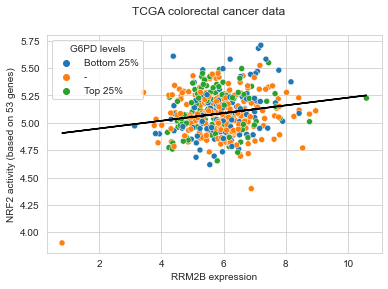

In [33]:
fig, axs = plt.subplots(1, 1, sharey=True)
sns.set_style("whitegrid")
sns.scatterplot(data=data, x="RRM2B", y="NFE2L2 activity", hue = "G6PD levels", color="green", ax=axs)
plt.plot(x, a*x+b, color="black")
axs.set_ylabel("NRF2 activity (based on 53 genes)")
axs.set_xlabel("RRM2B expression")
fig.suptitle('TCGA colorectal cancer data')
plt.show()

In [14]:
np.corrcoef(x, y)

array([[1.        , 0.17696793],
       [0.17696793, 1.        ]])